In [159]:
import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time

from typing import List, Text

from PIL import Image

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import tabulate


import tensorflow as tf

import matplotlib.pyplot as plt


In [160]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>1.Defines Global Parameters for GCP </b></h1>
</div>


In [161]:
#@title Global params

class Globals:
  # GCP project with GCS bucket of interest
  gcp_project = 'dx-scin-public' #@param

  # GCS bucket with data to read
  gcs_bucket_name = 'dx-scin-public-data' #@param

  # CSV of case metadata to read
  cases_csv = 'dataset/scin_cases.csv' #@param

  # CSV of label metadata to read
  labels_csv = 'dataset/scin_labels.csv' #@param

  # Images directory
  gcs_images_dir = 'dataset/images/' #@param

  ### Key column names
  image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
  weighted_skin_condition_label = "weighted_skin_condition_label"
  skin_condition_label = "dermatologist_skin_condition_on_label_name"

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  cases_df = None

  # pd.DataFrame for the loaded labels_csv
  cases_and_labels_df = None

print(f'GCS bucket name: {Globals.gcs_bucket_name}')
print(f'cases_csv: {Globals.cases_csv}')
print(f'labels_csv: {Globals.labels_csv}')
print(f'images dir: {Globals.gcs_images_dir}')


GCS bucket name: dx-scin-public-data
cases_csv: dataset/scin_cases.csv
labels_csv: dataset/scin_labels.csv
images dir: dataset/images/


<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>2.Intialize Google Cloud Storage client to Load CSV label files</b></h1>
</div>


In [162]:
#@title Create a dataframe that contains the metadata and condition labels

from google.cloud import storage

def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)

def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(
    Globals.gcs_bucket_name
)
Globals.cases_df = initialize_df_with_metadata(Globals.gcs_bucket, Globals.cases_csv)
Globals.cases_and_labels_df = augment_metadata_with_labels(Globals.cases_df, Globals.gcs_bucket, Globals.labels_csv)
print(len(Globals.cases_and_labels_df))

5033


In [163]:
Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [164]:
Globals.cases_and_labels_df.head(5)

,case_id,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,race_ethnicity_middle_eastern_or_north_african,race_ethnicity_native_hawaiian_or_pacific_islander,race_ethnicity_white,race_ethnicity_other_race,race_ethnicity_prefer_not_to_answer,textures_raised_or_bumpy,textures_flat,textures_rough_or_flaky,textures_fluid_filled,body_parts_head_or_neck,body_parts_arm,body_parts_palm,body_parts_back_of_hand,body_parts_torso_front,body_parts_torso_back,body_parts_genitalia_or_groin,body_parts_buttocks,body_parts_leg,body_parts_foot_top_or_side,body_parts_foot_sole,body_parts_other,condition_symptoms_bothersome_appearance,condition_symptoms_bleeding,condition_symptoms_increasing_size,condition_symptoms_darkening,condition_symptoms_itching,condition_symptoms_burning,condition_symptoms_pain,condition_symptoms_no_relevant_experience,other_symptoms_fever,other_symptoms_chills,other_symptoms_fatigue,other_symptoms_joint_pain,other_symptoms_mouth_sores,other_symptoms_shortness_of_breath,other_symptoms_no_relevant_symptoms,related_category,condition_duration,image_1_path,image_2_path,image_3_path,image_1_shot_type,image_2_shot_type,image_3_shot_type,combined_race,race_ethnicity_two_or_more_after_mitigation,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,dermatologist_skin_condition_on_label_name,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
0,-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,NaN,NaN,YES,YES,NaN,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,RASH,ONE_DAY,dataset/images/-3205742176803893704.png,NaN,NaN,CLOSE_UP,NaN,NaN,NaN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Inflicted skin lesions', 'Eczema', 'Irritant...","[4, 4, 3]","{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
1,-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/-4762289084741430925.png,NaN,NaN,CLOSE_UP,NaN,NaN,NaN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Prurigo nodularis', 'Actinic Keratosis', 'SC...","[4, 3, 4]","{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
2,-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,YES,YES,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,OTHER_ISSUE_DESCRIPTION,ONE_TO_FOUR_WEEKS,dataset/images/-4027806997035329030.png,NaN,NaN,CLOSE_UP,NaN,NaN,HISPANIC_LATINO_OR_SPANISH_ORIGIN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Impetigo', 'Herpes Zoster', 'Bullous dermati...","[2, 1, 1]","{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
3,-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,YES,NaN,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,OTHER_ISSUE_DESCRIPTION,ONE_DAY,dataset/images/-5332065579713135540.png,dataset/images/-63534317080649697

In [165]:
Globals.cases_and_labels_df.to_csv('Original_dataset.csv')

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>3.Display the random images </b></h1>
</div>


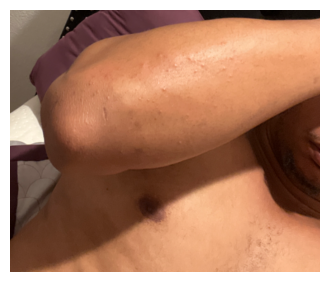

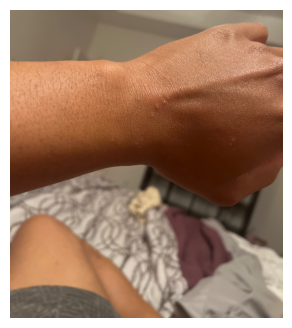

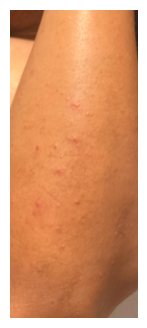

{'Folliculitis': 0.4, 'Acute dermatitis, NOS': 0.17, 'Milia': 0.1, 'Granuloma annulare': 0.1, 'CD - Contact dermatitis': 0.23}


In [166]:
#@title Display the images for a case (and condition labels, optionally)
import random
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def display_image(bucket, image_path):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size=4
  f, axarr = plt.subplots(1, 1, figsize = (figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

def display_images_for_case(df, case_id="", print_condition_labels=True):
  # Use a random case if none is provided:
  if case_id:
    matched_df = df[df['case_id'] == case_id]
  else:
    matched_df = df.sample(1)

  image_paths = matched_df[Globals.image_path_columns].values.tolist()[0]
  for path in image_paths:
    if isinstance(path, str):
      display_image(Globals.gcs_bucket, path)
  if print_condition_labels:
    condition_labels = matched_df[[Globals.weighted_skin_condition_label]].values.tolist()[0]
    for label in condition_labels:
      if isinstance(label, str):
        print(label)

# display_images_for_case(Globals.cases_and_labels_df, "-1000600354148496558")
display_images_for_case(Globals.cases_and_labels_df)


<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>4.Get the Missing Images </b></h1>
</div>


In [167]:
"""def is_valid_image_path(path):
    if isinstance(path, str):
        try:
            image = Image.open(io.BytesIO(Globals.gcs_bucket.blob(path).download_as_string()))
            return True
        except Exception as e:
            print(f"Invalid image path: {path}, Error: {e}")
            return False
    return False

# Apply the function to the image path columns in the dataframe
image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
for col in image_path_columns:
    Globals.cases_and_labels_df[col + '_valid'] = Globals.cases_and_labels_df[col].apply(is_valid_image_path)

# Display the first few rows of the dataframe with validity columns
print(Globals.cases_and_labels_df.head())"""

'def is_valid_image_path(path):\n    if isinstance(path, str):\n        try:\n            image = Image.open(io.BytesIO(Globals.gcs_bucket.blob(path).download_as_string()))\n            return True\n        except Exception as e:\n            print(f"Invalid image path: {path}, Error: {e}")\n            return False\n    return False\n\n# Apply the function to the image path columns in the dataframe\nimage_path_columns = [\'image_1_path\', \'image_2_path\', \'image_3_path\']\nfor col in image_path_columns:\n    Globals.cases_and_labels_df[col + \'_valid\'] = Globals.cases_and_labels_df[col].apply(is_valid_image_path)\n\n# Display the first few rows of the dataframe with validity columns\nprint(Globals.cases_and_labels_df.head())'

## The missing image path is : "**dataset/images/-2243186711511406658.png**"

In [168]:
Globals.cases_and_labels_df.loc[Globals.cases_and_labels_df['image_1_path'] == ' dataset/images/-2243186711511406658.png', 'image_1_path'] = ''

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>5.Reverse Engineering</b></h1>
</div>


In [169]:

one_hot_groups = {
    'race_ethnicity': [
        'race_ethnicity_american_indian_or_alaska_native',
        'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
        'race_ethnicity_hispanic_latino_or_spanish_origin',
        'race_ethnicity_middle_eastern_or_north_african',
        'race_ethnicity_native_hawaiian_or_pacific_islander',
        'race_ethnicity_white', 'race_ethnicity_other_race',
        'race_ethnicity_prefer_not_to_answer'
    ],
    'textures': [
        'textures_raised_or_bumpy', 'textures_flat',
        'textures_rough_or_flaky', 'textures_fluid_filled'
    ],
    'body_parts': [
        'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
        'body_parts_back_of_hand', 'body_parts_torso_front',
        'body_parts_torso_back', 'body_parts_genitalia_or_groin',
        'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
        'body_parts_foot_sole', 'body_parts_other'
    ],
    'condition_symptoms': [
        'condition_symptoms_bothersome_appearance',
        'condition_symptoms_bleeding', 'condition_symptoms_increasing_size',
        'condition_symptoms_darkening', 'condition_symptoms_itching',
        'condition_symptoms_burning', 'condition_symptoms_pain',
        'condition_symptoms_no_relevant_experience'
    ],
    'other_symptoms': [
        'other_symptoms_fever', 'other_symptoms_chills', 'other_symptoms_fatigue',
        'other_symptoms_joint_pain', 'other_symptoms_mouth_sores',
        'other_symptoms_shortness_of_breath', 'other_symptoms_no_relevant_symptoms'
    ]
}

# Iterate over each group in the one_hot_groups dictionary
for group, columns in one_hot_groups.items():
    # Create a new column with the group name
    Globals.cases_and_labels_df[group] = ''

    # Iterate over each column in the group
    for column in columns:
        # Update the new column with the category name where the corresponding one-hot encoded column is 'YES'
        Globals.cases_and_labels_df.loc[Globals.cases_and_labels_df[column] == 'YES', group] = column

# Print the columns of the updated DataFrame
print(Globals.cases_and_labels_df.columns)


Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [170]:
Globals.cases_and_labels_df.head(10)

,case_id,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,race_ethnicity_middle_eastern_or_north_african,race_ethnicity_native_hawaiian_or_pacific_islander,race_ethnicity_white,race_ethnicity_other_race,race_ethnicity_prefer_not_to_answer,textures_raised_or_bumpy,textures_flat,textures_rough_or_flaky,textures_fluid_filled,body_parts_head_or_neck,body_parts_arm,body_parts_palm,body_parts_back_of_hand,body_parts_torso_front,body_parts_torso_back,body_parts_genitalia_or_groin,body_parts_buttocks,body_parts_leg,body_parts_foot_top_or_side,body_parts_foot_sole,body_parts_other,condition_symptoms_bothersome_appearance,condition_symptoms_bleeding,condition_symptoms_increasing_size,condition_symptoms_darkening,condition_symptoms_itching,condition_symptoms_burning,condition_symptoms_pain,condition_symptoms_no_relevant_experience,other_symptoms_fever,other_symptoms_chills,other_symptoms_fatigue,other_symptoms_joint_pain,other_symptoms_mouth_sores,other_symptoms_shortness_of_breath,other_symptoms_no_relevant_symptoms,related_category,condition_duration,image_1_path,image_2_path,image_3_path,image_1_shot_type,image_2_shot_type,image_3_shot_type,combined_race,race_ethnicity_two_or_more_after_mitigation,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,dermatologist_skin_condition_on_label_name,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us,race_ethnicity,textures,body_parts,condition_symptoms,other_symptoms
0,-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,NaN,NaN,YES,YES,NaN,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,RASH,ONE_DAY,dataset/images/-3205742176803893704.png,NaN,NaN,CLOSE_UP,NaN,NaN,NaN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Inflicted skin lesions', 'Eczema', 'Irritant...","[4, 4, 3]","{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0,,textures_raised_or_bumpy,body_parts_foot_top_or_side,condition_symptoms_pain,other_symptoms_no_relevant_symptoms
1,-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dataset/images/-4762289084741430925.png,NaN,NaN,CLOSE_UP,NaN,NaN,NaN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Prurigo nodularis', 'Actinic Keratosis', 'SC...","[4, 3, 4]","{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0,,,,,
2,-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,YES,YES,NaN,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,YES,YES,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,OTHER_ISSUE_DESCRIPTION,ONE_TO_FOUR_WEEKS,dataset/images/-4027806997035329030.png,NaN,NaN,CLOSE_UP,NaN,NaN,HISPANIC_LATINO_OR_SPANISH_ORIGIN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Impetigo', 'Herpes Zoster', 'Bullous dermati...","[2, 1, 1]","{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0,race_ethnicity_hispanic_latino_or_spanish_origin,textures_rough_or_flaky,body_parts_arm,condition_symptoms_pain,other_symptoms_no_relevant_symptoms
3,-10

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>6.Drop One Hot Encoded Columns </b></h1>
</div>


In [171]:
# List to store columns to be dropped
columns_to_drop = []

# Iterate over each column in the original DataFrame
for column in Globals.cases_and_labels_df.columns:
    # Check if the column name starts with any prefix in the one_hot_groups dictionary
    for group, columns in one_hot_groups.items():
        if any(column.startswith(prefix) for prefix in columns):
            # Add column to be dropped to the list
            columns_to_drop.append(column)

# Drop the encoded columns
Globals.cases_and_labels_df.drop(columns=columns_to_drop, inplace=True)

Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type', 'related_category', 'condition_duration',
       'image_1_path', 'image_2_path', 'image_3_path', 'image_1_shot_type',
       'image_2_shot_type', 'image_3_shot_type', 'combined_race',
       'race_ethnicity_two_or_more_after_mitigation',
       'dermatologist_gradable_for_skin_condition_1',
       'dermatologist_gradable_for_skin_condition_2',
       'dermatologist_gradable_for_skin_condition_3',
       'dermatologist_skin_condition_on_label_name',
       'dermatologist_skin_condition_confidence',
       'weighted_skin_condition_label',
       'dermatologist_gradable_for_fitzpatrick_skin_type_1',
       'dermatologist_gradable_for_fitzpatrick_skin_type_2',
       'dermatologist_gradable_for_fitzpatrick_skin_type_3',
       'dermatologist_fitzpatrick_skin_type_label_1',
       'dermatologist_fitzpatrick_skin_type_label_2',
       'dermatologist_fitzpatrick_skin_type_label_3',
    

In [172]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
Globals.cases_and_labels_df.sample(20)


,case_id,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,related_category,condition_duration,image_1_path,image_2_path,image_3_path,image_1_shot_type,image_2_shot_type,image_3_shot_type,combined_race,race_ethnicity_two_or_more_after_mitigation,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,dermatologist_skin_condition_on_label_name,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us,race_ethnicity,textures,body_parts,condition_symptoms,other_symptoms
2694,1536558571491805560,SCIN,1.0.0,2023,AGE_18_TO_29,FEMALE,FST3,NaN,NaN,dataset/images/-8222627480578524710.png,dataset/images/7772443988445294086.png,NaN,AT_AN_ANGLE,CLOSE_UP,NaN,PREFER_NOT_TO_ANSWER,NaN,NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN,[],[],{},YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,2.0,race_ethnicity_prefer_not_to_answer,,,condition_symptoms_burning,other_symptoms_no_relevant_symptoms
2304,-8542064986886426986,SCIN,1.0.0,2023,AGE_UNKNOWN,MALE,FST2,RASH,LESS_THAN_ONE_WEEK,dataset/images/-3555487255426017347.png,dataset/images/3252880636526484617.png,dataset/images/8215374641081279021.png,AT_AN_ANGLE,AT_DISTANCE,CLOSE_UP,"HISPANIC_LATINO_OR_SPANISH_ORIGIN,WHITE",NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NO_IMAGE_QUALITY_INSUFFICIENT,"['Urticaria', 'Allergic Contact Dermatitis']","[3, 1]","{'Urticaria': 0.67, 'Allergic Contact Dermatit...",YES,YES,YES,FST2,FST1,FST2,True,True,2.0,1.0,race_ethnicity_white,textures_flat,body_parts_leg,condition_symptoms_burning,other_symptoms_no_relevant_symptoms
3088,282923208361277809,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,dataset/images/125607177245589668.png,NaN,NaN,CLOSE_UP,NaN,NaN,NaN,NaN,NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN,[],[],{},YES,NaN,NaN,FST3,NaN,NaN,True,True,4.0,3.0,,,,,
105,-1352892938664792412,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,dataset/images/-4176773000953294276.png,dataset/images/-7720050350557497359.png,dataset/images/5864091977006975234.png,AT_DISTANCE,CLOSE_UP,AT_AN_ANGLE,NaN,NaN,NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN,[],[],{},YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,5.0,,textures_fluid_filled,,,
1554,-6110101408648949573,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,RASH,ONE_TO_FOUR_WEEKS,dataset/images/-8406319565890157390.png,dataset/images/6641468760354802566.png,dataset/images/7110316403206851010.png,AT_DISTANCE,AT_AN_ANGLE,CLOSE_UP,NaN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Impetigo', 'Psoriasis', 'Seborrheic Dermatit...","[1, 1, 4]","{'Seborrheic Dermatitis': 0.55, 'Impetigo': 0....",YES,NaN,NaN,FST1,NaN,NaN,True,True,2.0,2.0,,textures_rough_or_flaky,body_parts_head_or_neck,,
2765,1758257439672934702,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,FST4,OTHER_ISSUE_DESCRIPTION,ONE_DAY,dataset/images/-4529991254357700468.png,dataset/images/-5967112197414294154.png,dataset/images/-8020442735008845217.png,AT_AN_ANGLE,CLOSE_UP,AT_DISTANCE,WHITE,NaN,NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN,[],[],{},NO,NaN,NaN,NaN,NaN,NaN,True,True,1.0,1.0,race_ethnicity_white,textures_fluid_filled,,condition_symptoms_pain,other_symptoms_mouth_sores
193,-1616454963494052359,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,dataset/images/-7632127675025789395.png,dataset/images/4769325170365798760.png,dataset/images/5241006123467003866.png,AT_DISTANCE,AT_AN_ANGLE,CLOSE_UP,NaN,NaN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Eczema', 'Lichen planus/lichenoid eruption',...","[1, 2, 1]","{'Lichen planus/lichenoid eruption': 0.55, 'E

In [173]:
Globals.cases_and_labels_df.columns.value_counts().sum()

38

In [174]:
Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type', 'related_category', 'condition_duration',
       'image_1_path', 'image_2_path', 'image_3_path', 'image_1_shot_type',
       'image_2_shot_type', 'image_3_shot_type', 'combined_race',
       'race_ethnicity_two_or_more_after_mitigation',
       'dermatologist_gradable_for_skin_condition_1',
       'dermatologist_gradable_for_skin_condition_2',
       'dermatologist_gradable_for_skin_condition_3',
       'dermatologist_skin_condition_on_label_name',
       'dermatologist_skin_condition_confidence',
       'weighted_skin_condition_label',
       'dermatologist_gradable_for_fitzpatrick_skin_type_1',
       'dermatologist_gradable_for_fitzpatrick_skin_type_2',
       'dermatologist_gradable_for_fitzpatrick_skin_type_3',
       'dermatologist_fitzpatrick_skin_type_label_1',
       'dermatologist_fitzpatrick_skin_type_label_2',
       'dermatologist_fitzpatrick_skin_type_label_3',
    

In [175]:
df = Globals.cases_and_labels_df
df.info()

# Missing columns
"""
fitzpatrick_skin_type 2503
related_category 3779
condition_duration 4036
image_3_path != image_3_shot_type
combined_race 2652
race_ethnicity_two_or_more_after_mitigation 83
dermatologist_fitzpatrick_skin_type_label_1 4302
gradable_for_monk_skin_tone_india  5023
gradable_for_monk_skin_tone_us 5023
monk_skin_tone_label_india 5019
monk_skin_tone_label_us 5005
"""

# unbalaced columns : Drop or Fix?
"""
fitzpatrick_skin_type
combined_race
race_ethnicity_two_or_more_after_mitigation
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 38 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   object 
 1   source                                              5033 non-null   object 
 2   release                                             5033 non-null   object 
 3   year                                                5033 non-null   int64  
 4   age_group                                           5032 non-null   object 
 5   sex_at_birth                                        5032 non-null   object 
 6   fitzpatrick_skin_type                               2503 non-null   object 
 7   related_category                                    3779 non-null   object 
 8   condition_duration                                  4036 non-null   object 
 9

'\nfitzpatrick_skin_type\ncombined_race\nrace_ethnicity_two_or_more_after_mitigation\n'

In [176]:
import pandas as pd

# Assuming df is your DataFrame
# Example: df = pd.read_csv('your_data.csv')

columns = {
    'fitzpatrick_skin_type': 2503,
    'related_category': 3779,
    'condition_duration': 4036,
    'combined_race': 2652,
    'race_ethnicity_two_or_more_after_mitigation': 83,
    'dermatologist_fitzpatrick_skin_type_label': 4370,
    'gradable_for_monk_skin_tone_india': 5023,
    'gradable_for_monk_skin_tone_us': 5023,
    'monk_skin_tone_label_india': 5019,
    'monk_skin_tone_label_us': 5005
}

for column, expected_sum in columns.items():
    if column in df.columns:
        value_counts = df[column].value_counts()
        actual_sum = value_counts.sum()
        print(f"{column}:")
        print(value_counts)
        print(f"Sum of values: {actual_sum} (Expected: {expected_sum})\n")
    else:
        print(f"Column '{column}' does not exist in the dataframe.\n")


fitzpatrick_skin_type:
fitzpatrick_skin_type
FST3               661
FST2               542
FST4               427
NONE_IDENTIFIED    328
FST5               214
FST1               188
FST6               143
Name: count, dtype: int64
Sum of values: 2503 (Expected: 2503)

related_category:
related_category
RASH                       2876
OTHER_ISSUE_DESCRIPTION     414
LOOKS_HEALTHY               290
ACNE                         74
GROWTH_OR_MOLE               45
PIGMENTARY_PROBLEM           37
NAIL_PROBLEM                 20
OTHER_HAIR_PROBLEM           12
HAIR_LOSS                    11
Name: count, dtype: int64
Sum of values: 3779 (Expected: 3779)

condition_duration:
condition_duration
LESS_THAN_ONE_WEEK        1386
ONE_TO_FOUR_WEEKS          960
ONE_DAY                    784
ONE_TO_THREE_MONTHS        318
THREE_TO_TWELVE_MONTHS     237
MORE_THAN_ONE_YEAR         201
MORE_THAN_FIVE_YEARS        91
UNKNOWN                     39
SINCE_CHILDHOOD             20
Name: count, dtype: int64

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 38 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   object 
 1   source                                              5033 non-null   object 
 2   release                                             5033 non-null   object 
 3   year                                                5033 non-null   int64  
 4   age_group                                           5032 non-null   object 
 5   sex_at_birth                                        5032 non-null   object 
 6   fitzpatrick_skin_type                               2503 non-null   object 
 7   related_category                                    3779 non-null   object 
 8   condition_duration                                  4036 non-null   object 
 9

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>7.Feature Engineering </b></h1>
</div>


In [178]:
gradable_columns1 = ['dermatologist_gradable_for_skin_condition_1',
                     'dermatologist_gradable_for_skin_condition_2',
                     'dermatologist_gradable_for_skin_condition_3']

gradable_columns2 = ['dermatologist_gradable_for_fitzpatrick_skin_type_1',
                     'dermatologist_gradable_for_fitzpatrick_skin_type_2', # fixed typo
                     'dermatologist_gradable_for_fitzpatrick_skin_type_3'] # fixed typo

gradable_columns3 = ['dermatologist_fitzpatrick_skin_type_label_1',
                     'dermatologist_fitzpatrick_skin_type_label_2',
                     'dermatologist_fitzpatrick_skin_type_label_3']

# Function to calculate the mode for each row
def calculate_mode(row):
    return row.mode().iloc[0] if not row.mode().empty else None

# Apply the mode calculation for each set of columns
df['dermatologist_gradable_for_skin_condition_1'] = df[gradable_columns1].apply(calculate_mode, axis=1)
df['dermatologist_gradable_for_fitzpatrick_skin_type_1'] = df[gradable_columns2].apply(calculate_mode, axis=1)
df['dermatologist_fitzpatrick_skin_type_label_1'] = df[gradable_columns3].apply(calculate_mode, axis=1)

In [179]:
df['dermatologist_gradable_for_skin_condition_1'].value_counts().sum()

5033

In [180]:

df['dermatologist_gradable_for_fitzpatrick_skin_type_1'].value_counts().sum()

5033

In [181]:
df['dermatologist_fitzpatrick_skin_type_label_1'].value_counts().sum()

4370

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>8.Impute the Missing Values & Fix the Unbalanced Data </b></h1>
</div>


### Impute dermatologist_fitzpatrick_skin_type_label_1

In [182]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Encode the categorical labels
le = LabelEncoder()
df['dermatologist_fitzpatrick_skin_type_label_1_encoded'] = le.fit_transform(df['dermatologist_fitzpatrick_skin_type_label_1'].astype(str))

# Impute missing values using the most frequent value strategy
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(df[['dermatologist_fitzpatrick_skin_type_label_1_encoded']])

# Decode the imputed values back to the original labels
df['dermatologist_fitzpatrick_skin_type_label_1_imputed'] = le.inverse_transform(imputed_data.astype(int).ravel())


In [183]:
df['dermatologist_fitzpatrick_skin_type_label_1_imputed'].value_counts().sum()

5033

In [184]:
df['dermatologist_fitzpatrick_skin_type_label'] = df['dermatologist_fitzpatrick_skin_type_label_1_imputed']
df.drop(['dermatologist_fitzpatrick_skin_type_label_1_imputed','dermatologist_fitzpatrick_skin_type_label_1_encoded'], axis =1,inplace = True)
df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type', 'related_category', 'condition_duration',
       'image_1_path', 'image_2_path', 'image_3_path', 'image_1_shot_type',
       'image_2_shot_type', 'image_3_shot_type', 'combined_race',
       'race_ethnicity_two_or_more_after_mitigation',
       'dermatologist_gradable_for_skin_condition_1',
       'dermatologist_gradable_for_skin_condition_2',
       'dermatologist_gradable_for_skin_condition_3',
       'dermatologist_skin_condition_on_label_name',
       'dermatologist_skin_condition_confidence',
       'weighted_skin_condition_label',
       'dermatologist_gradable_for_fitzpatrick_skin_type_1',
       'dermatologist_gradable_for_fitzpatrick_skin_type_2',
       'dermatologist_gradable_for_fitzpatrick_skin_type_3',
       'dermatologist_fitzpatrick_skin_type_label_1',
       'dermatologist_fitzpatrick_skin_type_label_2',
       'dermatologist_fitzpatrick_skin_type_label_3',
    

In [185]:
df['dermatologist_fitzpatrick_skin_type_label'] = df['dermatologist_fitzpatrick_skin_type_label'].replace('None', np.nan)

In [186]:
df['dermatologist_fitzpatrick_skin_type_label'].value_counts()

dermatologist_fitzpatrick_skin_type_label
FST2    1491
FST3    1351
FST4     716
FST1     381
FST5     364
FST6      67
Name: count, dtype: int64

In [187]:
df['monk_skin_tone_label_us'].value_counts()

monk_skin_tone_label_us
2.0     1660
3.0     1265
4.0      687
1.0      577
5.0      361
6.0      248
7.0      137
8.0       57
9.0       11
10.0       2
Name: count, dtype: int64

In [188]:
df['monk_skin_tone_label_india'].value_counts()

monk_skin_tone_label_india
2.0    2427
3.0    1591
4.0     522
1.0     187
5.0     177
6.0      63
7.0      35
8.0      14
9.0       3
Name: count, dtype: int64

### Impute monk skin tone

In [189]:
from sklearn.impute import SimpleImputer

# Define the imputer with strategy as 'most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in 'monk_skin_tone_label_india'
df['monk_skin_tone_label_india'] = imputer.fit_transform(df[['monk_skin_tone_label_india']])

# Impute missing values in 'monk_skin_tone_label_us'
df['monk_skin_tone_label_us'] = imputer.fit_transform(df[['monk_skin_tone_label_us']])


In [190]:
df['dermatologist_fitzpatrick_skin_type_label'].value_counts()

dermatologist_fitzpatrick_skin_type_label
FST2    1491
FST3    1351
FST4     716
FST1     381
FST5     364
FST6      67
Name: count, dtype: int64

### We can Predict the missing values of Fitzpatrick from Monk skin tone scale

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame
# Encode the target variable
le = LabelEncoder()
df['dermatologist_fitzpatrick_skin_type_label_encoded'] = le.fit_transform(df['dermatologist_fitzpatrick_skin_type_label'].astype(str))

# Split the data into training and prediction sets
train_df = df.dropna(subset=['dermatologist_fitzpatrick_skin_type_label'])
predict_df = df[df['dermatologist_fitzpatrick_skin_type_label'].isnull()]

# Features and target variable for training
X_train = train_df[['monk_skin_tone_label_us', 'monk_skin_tone_label_india']]
y_train = train_df['dermatologist_fitzpatrick_skin_type_label_encoded']

# Features for prediction
X_predict = predict_df[['monk_skin_tone_label_us', 'monk_skin_tone_label_india']]

# Train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the missing values
predictions = clf.predict(X_predict)

# Decode the predicted labels
predicted_labels = le.inverse_transform(predictions)

# Fill the missing values in the original DataFrame
df.loc[df['dermatologist_fitzpatrick_skin_type_label'].isnull(), 'dermatologist_fitzpatrick_skin_type_label'] = predicted_labels

# Drop the encoded target column as it is no longer needed
df.drop(columns=['dermatologist_fitzpatrick_skin_type_label_encoded'], inplace=True)


In [192]:
df['dermatologist_fitzpatrick_skin_type_label'].value_counts().sum()

5033

### Predict the missing values of gradable monk skin tone

In [193]:
# Importing necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

# Selecting features and target variable
X_train = df.dropna(subset=['gradable_for_monk_skin_tone_us'])[['monk_skin_tone_label_us']]
y_train = df.dropna(subset=['gradable_for_monk_skin_tone_us'])['gradable_for_monk_skin_tone_us']

# Initializing and training the model
model = RandomForestRegressor(random_state=42)
predicted_values = cross_val_predict(model, X_train, y_train, cv=5)

# Predict missing values
missing_data_indices = df[df['gradable_for_monk_skin_tone_us'].isnull()].index
predicted_values_subset = predicted_values[:len(missing_data_indices)]

# Update DataFrame with predicted values
df.loc[missing_data_indices, 'gradable_for_monk_skin_tone_us'] = predicted_values_subset


In [194]:
# Importing necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

# Selecting features and target variable
X_train = df.dropna(subset=['gradable_for_monk_skin_tone_india'])[['monk_skin_tone_label_india']]
y_train = df.dropna(subset=['gradable_for_monk_skin_tone_india'])['gradable_for_monk_skin_tone_india']

# Initializing and training the model
model = RandomForestRegressor(random_state=42)
predicted_values = cross_val_predict(model, X_train, y_train, cv=5)

# Predict missing values
missing_data_indices = df[df['gradable_for_monk_skin_tone_india'].isnull()].index
predicted_values_subset = predicted_values[:len(missing_data_indices)]

# Update DataFrame with predicted values
df.loc[missing_data_indices, 'gradable_for_monk_skin_tone_india'] = predicted_values_subset



### Predict the combined race type from the fitzpatrick skin scale

In [195]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict

# Example DataFrame structure (assuming df is already defined)
# df = pd.DataFrame({...})

# Prepare the training data
X_train = df.dropna(subset=['combined_race'])[['dermatologist_fitzpatrick_skin_type_label']]
y_train = df.dropna(subset=['combined_race'])['combined_race']

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Encoding the feature
feature_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(X_train.values.ravel()).reshape(-1, 1)

# Initializing and training the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded, y_train_encoded)

# Predict missing values for combined_race
X_predict = df[df['combined_race'].isnull()][['dermatologist_fitzpatrick_skin_type_label']]
X_predict_encoded = feature_encoder.transform(X_predict.values.ravel()).reshape(-1, 1)

# Make predictions
predicted_values_encoded = model.predict(X_predict_encoded)

# Decode the predicted values
predicted_values = label_encoder.inverse_transform(predicted_values_encoded)

# Update DataFrame with predicted values
df.loc[df['combined_race'].isnull(), 'combined_race'] = predicted_values



In [196]:
df['combined_race'].value_counts().sum()

5033

### Predict the user given fitzpatrick skin type using the race ethnicity feature

In [197]:
# Split the dataset into training and test sets
from sklearn.preprocessing import LabelEncoder

train_data = df.dropna(subset=["fitzpatrick_skin_type", "race_ethnicity"])
test_data = df[df["fitzpatrick_skin_type"].isnull()]

# Encode categorical variables
label_encoder = LabelEncoder()
train_data["race_ethnicity_encoded"] = label_encoder.fit_transform(train_data["race_ethnicity"])
test_data["race_ethnicity_encoded"] = label_encoder.transform(test_data["race_ethnicity"])

# Define features and target variable
features = ["race_ethnicity_encoded"]
target = "fitzpatrick_skin_type"

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data[features], train_data[target])

# Predict missing values
predicted_skin_types = rf_classifier.predict(test_data[features])

# Update the missing values in the original dataset
df.loc[df["fitzpatrick_skin_type"].isnull(), "fitzpatrick_skin_type"] = predicted_skin_types


<ipython-input-197-e3e7501ab42c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["race_ethnicity_encoded"] = label_encoder.fit_transform(train_data["race_ethnicity"])
<ipython-input-197-e3e7501ab42c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["race_ethnicity_encoded"] = label_encoder.transform(test_data["race_ethnicity"])


In [198]:
df['fitzpatrick_skin_type'].value_counts().sum()

5033

### Replcae the missing values of condition_duration and related_category columns with unknwon (you can predict the values in this columns using CNN for the images)

In [199]:
columns_to_replace = ['race_ethnicity', 'textures', 'body_parts', 'condition_symptoms', 'other_symptoms']
df[columns_to_replace] = df[columns_to_replace].replace('', np.nan)

In [200]:
df['condition_duration'] = df['condition_duration'].replace(np.nan, 'UNKNOWN')
df['related_category'] = df['related_category'].replace(np.nan, 'OTHER_ISSUE_DESCRIPTION')

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>9.Droping Columns </b></h1>
</div>

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 39 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   object 
 1   source                                              5033 non-null   object 
 2   release                                             5033 non-null   object 
 3   year                                                5033 non-null   int64  
 4   age_group                                           5032 non-null   object 
 5   sex_at_birth                                        5032 non-null   object 
 6   fitzpatrick_skin_type                               5033 non-null   object 
 7   related_category                                    5033 non-null   object 
 8   condition_duration                                  5033 non-null   object 
 9

In [202]:
for column in df.columns:
    print(df[column].value_counts())
    print('========================================================')


case_id
-1000600354148496558    1
3798503331105153312     1
3840593403086739651     1
3831326209815553185     1
3818341938433690215     1
                       ..
-6485961062381271236    1
-6485947403303154678    1
-6485920953755598815    1
-6484363516740850665    1
998890198757718998      1
Name: count, Length: 5033, dtype: int64
source
SCIN    5033
Name: count, dtype: int64
release
1.0.0    5033
Name: count, dtype: int64
year
2023    5033
Name: count, dtype: int64
age_group
AGE_UNKNOWN     2864
AGE_18_TO_29     769
AGE_40_TO_49     435
AGE_30_TO_39     422
AGE_50_TO_59     322
AGE_60_TO_69     165
AGE_70_TO_79      55
Name: count, dtype: int64
sex_at_birth
OTHER_OR_UNSPECIFIED    2559
FEMALE                  1666
MALE                     807
Name: count, dtype: int64
fitzpatrick_skin_type
FST3               3140
FST2                542
FST4                449
NONE_IDENTIFIED     357
FST5                214
FST1                188
FST6                143
Name: count, dtype: int64
rel

In [203]:
indices_to_remove = [0, 1, 2, 3, 16, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30]
df.drop(df.columns[indices_to_remove], axis=1, inplace=True)

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 23 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   age_group                                           5032 non-null   object 
 1   sex_at_birth                                        5032 non-null   object 
 2   fitzpatrick_skin_type                               5033 non-null   object 
 3   related_category                                    5033 non-null   object 
 4   condition_duration                                  5033 non-null   object 
 5   image_1_path                                        5033 non-null   object 
 6   image_2_path                                        3085 non-null   object 
 7   image_3_path                                        2289 non-null   object 
 8   image_1_shot_type                                   5033 non-null   object 
 9

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>10.feature Engineering Part 2 </b></h1>
</div>

In [205]:
import re
def get_expected_condition(condition_str):
    if condition_str == '{}':
        return None

    # Extract key-value pairs
    pairs = re.findall(r"'(.*?)': ([\d.]+)", condition_str)

    if not pairs:
        return None

    # Find the key with the maximum value
    max_key = max(pairs, key=lambda x: float(x[1]))[0]
    return max_key

# Apply the function to the DataFrame
df['Expected Condition'] = df['weighted_skin_condition_label'].apply(get_expected_condition)
df['Expected Condition'].value_counts().sum()

3061

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>11.Rename the Columns and its Values </b></h1>
</div>


In [206]:
df.head(10)

,age_group,sex_at_birth,fitzpatrick_skin_type,related_category,condition_duration,image_1_path,image_2_path,image_3_path,image_1_shot_type,image_2_shot_type,image_3_shot_type,combined_race,dermatologist_gradable_for_skin_condition_1,weighted_skin_condition_label,dermatologist_gradable_for_fitzpatrick_skin_type_1,monk_skin_tone_label_india,monk_skin_tone_label_us,race_ethnicity,textures,body_parts,condition_symptoms,other_symptoms,dermatologist_fitzpatrick_skin_type_label,Expected Condition
0,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST3,RASH,ONE_DAY,dataset/images/-3205742176803893704.png,NaN,NaN,CLOSE_UP,NaN,NaN,WHITE,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",YES,2.0,1.0,NaN,textures_raised_or_bumpy,body_parts_foot_top_or_side,condition_symptoms_pain,other_symptoms_no_relevant_symptoms,FST2,Inflicted skin lesions
1,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST3,OTHER_ISSUE_DESCRIPTION,UNKNOWN,dataset/images/-4762289084741430925.png,NaN,NaN,CLOSE_UP,NaN,NaN,WHITE,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",YES,3.0,3.0,NaN,NaN,NaN,NaN,NaN,FST1,Prurigo nodularis
2,AGE_18_TO_29,MALE,NONE_IDENTIFIED,OTHER_ISSUE_DESCRIPTION,ONE_TO_FOUR_WEEKS,dataset/images/-4027806997035329030.png,NaN,NaN,CLOSE_UP,NaN,NaN,HISPANIC_LATINO_OR_SPANISH_ORIGIN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",YES,3.0,4.0,race_ethnicity_hispanic_latino_or_spanish_origin,textures_rough_or_flaky,body_parts_arm,condition_symptoms_pain,other_symptoms_no_relevant_symptoms,FST4,Impetigo
3,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST3,OTHER_ISSUE_DESCRIPTION,ONE_DAY,dataset/images/-5332065579713135540.png,dataset/images/-6353431708064969797.png,dataset/images/742075435141960831.png,AT_DISTANCE,AT_AN_ANGLE,CLOSE_UP,WHITE,NO_IMAGE_QUALITY_INSUFFICIENT,{},NO,2.0,4.0,NaN,textures_rough_or_flaky,body_parts_palm,condition_symptoms_pain,other_symptoms_no_relevant_symptoms,FST2,None
4,AGE_40_TO_49,FEMALE,FST3,RASH,ONE_DAY,dataset/images/-3799298995660217860.png,dataset/images/-5881426422999442186.png,dataset/images/5854025080806696361.png,AT_AN_ANGLE,AT_DISTANCE,CLOSE_UP,WHITE,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Lichen planus/lichenoid eruption': 0.33, 'Fo...",YES,1.0,1.0,race_ethnicity_white,textures_flat,body_parts_foot_top_or_side,condition_symptoms_itching,other_symptoms_no_relevant_symptoms,FST1,Lichen planus/lichenoid eruption
5,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST3,RASH,LESS_THAN_ONE_WEEK,dataset/images/-3575683440831198879.png,dataset/images/6164754101533643044.png,dataset/images/7125798012232703466.png,CLOSE_UP,AT_AN_ANGLE,AT_DISTANCE,WHITE,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Drug Rash': 0.41, 'Viral Exanthem': 0.41, 'E...",YES,2.0,2.0,NaN,textures_raised_or_bumpy,body_parts_genitalia_or_groin,condition_symptoms_itching,other_symptoms_no_relevant_symptoms,FST3,Drug Rash
6,AGE_40_TO_49,FEMALE,FST1,RASH,LESS_THAN_ONE_WEEK,dataset/images/-6942912841265248602.png,dataset/images/-815168034213335912.png,dataset/images/8479707042238010445.png,AT_AN_ANGLE,AT_DISTANCE,CLOSE_UP,HISPANIC_LATINO_OR_SPANISH_ORIGIN,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Urticaria': 0.6, 'Leukocytoclastic Vasculiti...",YES,3.0,3.0,race_ethnicity_hispanic_latino_or_spanish_origin,textures_raised_or_bumpy,body_parts_palm,condition_symptoms_burning,other_symptoms_no_relevant_symptoms,FST4,Urticaria
7,AGE_UNKNOWN,MALE,FST4,RASH,ONE_TO_THREE_MONTHS,dataset/images/-220649468572111832.png,NaN,NaN,CLOSE_UP,NaN,NaN,WHITE,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"{'Basal Cell Carcinoma': 0.55, 'Inflicted skin...",YES,3.0,4.0,race_ethnicity_white,textures_raised_or_bumpy,body_parts_torso_back,condition_symptoms_pain,other_symptoms_no_relevant_symptoms,FST3,Basal Cell Carcinoma
8,AGE_18_TO_29,MALE,FST2,RASH,ONE_TO_THREE_MONTHS,dataset/images/-217828380359571871.png,dataset/images/-4055728304670056584.png,NaN,CLOSE_UP,AT_AN_ANGLE,NaN,HISPANIC_LATINO_OR_SPANISH_ORIGIN,DEFAULT_YES_IMAGE_QUALITY_SU

In [207]:
# Assuming df is your DataFrame
df['age_group'] = df['age_group'].str.lower()
df['age_group'] = df['age_group'].str.replace('AGE_', '')  # Remove the prefix 'AGE_'
df['age_group'] = df['age_group'].str.replace('_TO_', ' to ')
df['age_group'].value_counts()

age_group
age_unknown     2864
age_18_to_29     769
age_40_to_49     435
age_30_to_39     422
age_50_to_59     322
age_60_to_69     165
age_70_to_79      55
Name: count, dtype: int64

In [208]:
df['related_category'] = df['related_category'].str.lower()
df['related_category'] = df['related_category'].str.replace('_',' ')
df['related_category'].value_counts()

related_category
rash                       2876
other issue description    1668
looks healthy               290
acne                         74
growth or mole               45
pigmentary problem           37
nail problem                 20
other hair problem           12
hair loss                    11
Name: count, dtype: int64

In [209]:
df['condition_duration'] = df['condition_duration'].str.replace('_', ' ')
df['condition_duration'] = df['condition_duration'].str.lower()
df['condition_duration'].value_counts()

condition_duration
less than one week        1386
unknown                   1036
one to four weeks          960
one day                    784
one to three months        318
three to twelve months     237
more than one year         201
more than five years        91
since childhood             20
Name: count, dtype: int64

In [210]:
df['image_1_shot_type'] = df['image_1_shot_type'].str.replace('_',' ')
df['image_1_shot_type'] = df['image_1_shot_type'].str.lower()

df['image_2_shot_type'] = df['image_2_shot_type'].str.replace('_',' ')
df['image_2_shot_type'] = df['image_2_shot_type'].str.lower()

df['image_3_shot_type'] = df['image_3_shot_type'].str.replace('_',' ')
df['image_3_shot_type'] = df['image_3_shot_type'].str.lower()
df['image_1_shot_type'].value_counts()


image_1_shot_type
close up       3082
at an angle    1139
at distance     812
Name: count, dtype: int64

In [211]:
df['sex_at_birth'] = df['sex_at_birth'].str.replace('_', ' ')
df['sex_at_birth'] = df['sex_at_birth'].str.lower()
df['sex_at_birth'] = df['sex_at_birth'].replace('other or unspecified', 'unspecified')
df['sex_at_birth'].value_counts()

sex_at_birth
unspecified    2559
female         1666
male            807
Name: count, dtype: int64

In [212]:
df['fitzpatrick_skin_type'] = df['fitzpatrick_skin_type'].str.replace('_', ' ')
df['fitzpatrick_skin_type'] = df['fitzpatrick_skin_type'].str.lower()
df['fitzpatrick_skin_type'].value_counts()

fitzpatrick_skin_type
fst3               3140
fst2                542
fst4                449
none identified     357
fst5                214
fst1                188
fst6                143
Name: count, dtype: int64

In [213]:
df['combined_race'] = df['combined_race'].str.replace('_', ' ')
df['combined_race'] = df['combined_race'].str.lower()

replacement_dict = {
    'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT': 'quality sufficient',
    'NO_IMAGE_QUALITY_INSUFFICIENT': 'quality insufficient',
    'YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY': 'sufficient with no pathology'
}
df['dermatologist_gradable_for_skin_condition_1'] = df['dermatologist_gradable_for_skin_condition_1'].replace(replacement_dict)

df['race_ethnicity'] = df['race_ethnicity'].str.split('race_ethnicity').str[1]
df['race_ethnicity'] = df['race_ethnicity'].str.lower()
df['race_ethnicity'] = df['race_ethnicity'].str.replace('_', ' ')


In [214]:
df['body_parts'] = df['body_parts'].str.split('body_parts').str[1]
df['body_parts'] = df['body_parts'].str.lower()
df['body_parts'] = df['body_parts'].str.replace('_', ' ')

df['condition_symptoms'] = df['condition_symptoms'].str.split('condition_symptoms').str[1]
df['condition_symptoms'] = df['condition_symptoms'].str.lower()
df['condition_symptoms'] = df['condition_symptoms'].str.replace('_', ' ')

df['other_symptoms'] = df['other_symptoms'].str.split('other_symptoms').str[1]
df['other_symptoms'] = df['other_symptoms'].str.lower()
df['other_symptoms'] = df['other_symptoms'].str.replace('_', ' ')

In [215]:
df['textures'] = df['textures'].str.split('textures').str[1]
df['textures'] = df['textures'].str.lower()
df['textures'] = df['textures'].str.replace('_', ' ')

In [216]:
df.drop(['race_ethnicity', 'image_2_path', 'image_3_path', 'image_2_shot_type', 'image_3_shot_type'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 19 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   age_group                                           5032 non-null   object 
 1   sex_at_birth                                        5032 non-null   object 
 2   fitzpatrick_skin_type                               5033 non-null   object 
 3   related_category                                    5033 non-null   object 
 4   condition_duration                                  5033 non-null   object 
 5   image_1_path                                        5033 non-null   object 
 6   image_1_shot_type                                   5033 non-null   object 
 7   combined_race                                       5033 non-null   object 
 8   dermatologist_gradable_for_skin_condition_1         5033 non-null   object 
 9

In [217]:
from sklearn.impute import SimpleImputer


columns_to_impute = ['textures', 'body_parts', 'condition_symptoms', 'other_symptoms', 'Expected Condition']

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='most_frequent')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [218]:
df['image_1_path'] = df['image_1_path'].apply(lambda x: x.split('/')[-1])

In [219]:
df.rename(columns={'fitzpatrick_skin_type':'fitzpatrick_scale',
                   'image_1_shot_type' : 'image_shot',
                   'dermatologist_gradable_for_skin_condition_1': 'image_sufficiency',
                   'dermatologist_fitzpatrick_skin_type_label': 'dermatologist_fitzpatrick_diagnosis',
                   'dermatologist_gradable_for_fitzpatrick_skin_type_1': 'dermatologist_gradable_fitzpatrick_diagnosis',
                   'image_1_path':'image_name'}, inplace=True)
df.head(10)

,age_group,sex_at_birth,fitzpatrick_scale,related_category,condition_duration,image_name,image_shot,combined_race,image_sufficiency,weighted_skin_condition_label,dermatologist_gradable_fitzpatrick_diagnosis,monk_skin_tone_label_india,monk_skin_tone_label_us,textures,body_parts,condition_symptoms,other_symptoms,dermatologist_fitzpatrick_diagnosis,Expected Condition
0,age_unknown,unspecified,fst3,rash,one day,-3205742176803893704.png,close up,white,quality sufficient,"{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",YES,2.0,1.0,raised or bumpy,foot top or side,pain,no relevant symptoms,FST2,Inflicted skin lesions
1,age_unknown,unspecified,fst3,other issue description,unknown,-4762289084741430925.png,close up,white,quality sufficient,"{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",YES,3.0,3.0,raised or bumpy,leg,itching,no relevant symptoms,FST1,Prurigo nodularis
2,age_18_to_29,male,none identified,other issue description,one to four weeks,-4027806997035329030.png,close up,hispanic latino or spanish origin,quality sufficient,"{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",YES,3.0,4.0,rough or flaky,arm,pain,no relevant symptoms,FST4,Impetigo
3,age_unknown,unspecified,fst3,other issue description,one day,-5332065579713135540.png,at distance,white,quality insufficient,{},NO,2.0,4.0,rough or flaky,palm,pain,no relevant symptoms,FST2,None
4,age_40_to_49,female,fst3,rash,one day,-3799298995660217860.png,at an angle,white,quality sufficient,"{'Lichen planus/lichenoid eruption': 0.33, 'Fo...",YES,1.0,1.0,flat,foot top or side,itching,no relevant symptoms,FST1,Lichen planus/lichenoid eruption
5,age_unknown,unspecified,fst3,rash,less than one week,-3575683440831198879.png,close up,white,quality sufficient,"{'Drug Rash': 0.41, 'Viral Exanthem': 0.41, 'E...",YES,2.0,2.0,raised or bumpy,genitalia or groin,itching,no relevant symptoms,FST3,Drug Rash
6,age_40_to_49,female,fst1,rash,less than one week,-6942912841265248602.png,at an angle,hispanic latino or spanish origin,quality sufficient,"{'Urticaria': 0.6, 'Leukocytoclastic Vasculiti...",YES,3.0,3.0,raised or bumpy,palm,burning,no relevant symptoms,FST4,Urticaria
7,age_unknown,male,fst4,rash,one to three months,-220649468572111832.png,close up,white,quality sufficient,"{'Basal Cell Carcinoma': 0.55, 'Inflicted skin...",YES,3.0,4.0,raised or bumpy,torso back,pain,no relevant symptoms,FST3,Basal Cell Carcinoma
8,age_18_to_29,male,fst2,rash,one to three months,-217828380359571871.png,close up,hispanic latino or spanish origin,quality sufficient,"{'Eczema': 0.67, 'Psoriasis': 0.11, 'Acute and...",YES,2.0,4.0,flat,arm,darkening,no relevant symptoms,FST4,Eczema
9,age_unknown,unspecified,fst3,other issue description,unknown,8406712750126834903.png,close up,white,quality sufficient,{'Purpura': 1.0},YES,3.0,3.0,raised or bumpy,leg,itching,no relevant symptoms,FST4,Purpura


In [220]:
df.to_csv('Preproccessed_dataset.csv')

<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>12.Data Visualization & Insights. </b></h1>
</div>


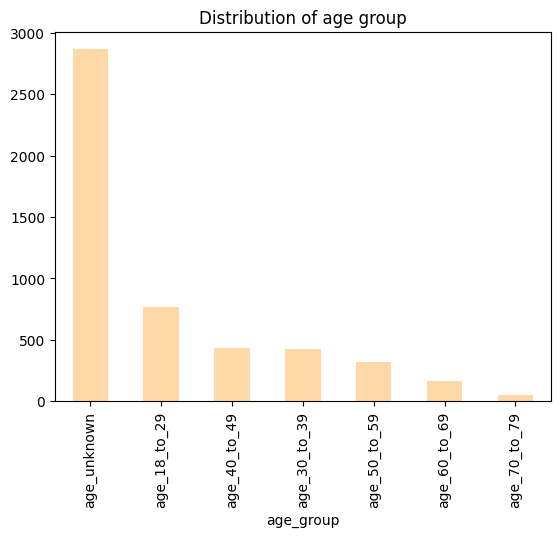

In [221]:
df['age_group'].value_counts().plot(kind='bar', color='#ffd8a7')
plt.title('Distribution of age group')
plt.show()

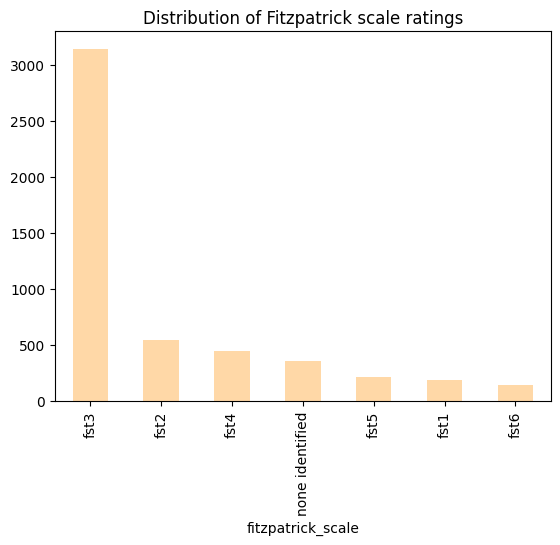

In [222]:
df['fitzpatrick_scale'].value_counts().plot(kind='bar', color='#ffd8a7')
plt.title('Distribution of Fitzpatrick scale ratings')
plt.show()


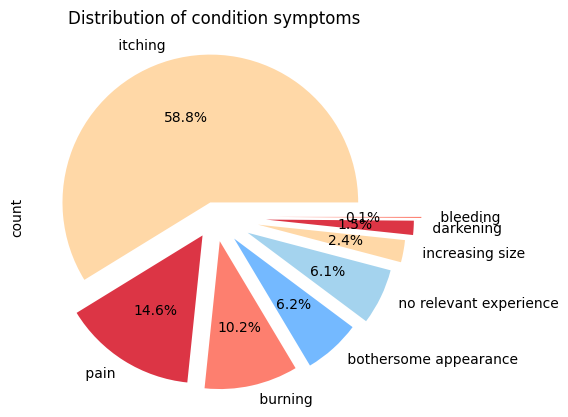

In [223]:

df['condition_symptoms'].value_counts().plot(kind='pie',autopct='%1.1f%%', explode=[0.1, 0.15, 0.17, 0.2, 0.25, 0.3,0.35, 0.4],colors = ['#ffd8a7','#dc3545','#fd7f6f','#74b9ff','#a4d3ee'])
plt.title('Distribution of condition symptoms')
plt.show()


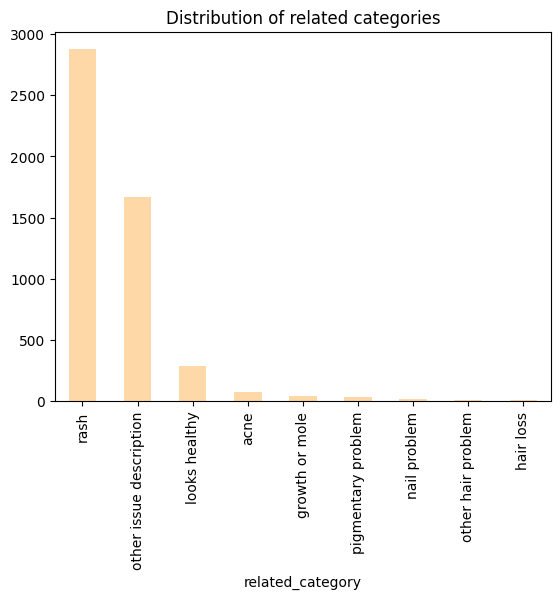

In [224]:

df['related_category'].value_counts().plot(kind='bar', color='#ffd8a7')
plt.title('Distribution of related categories')
plt.show()


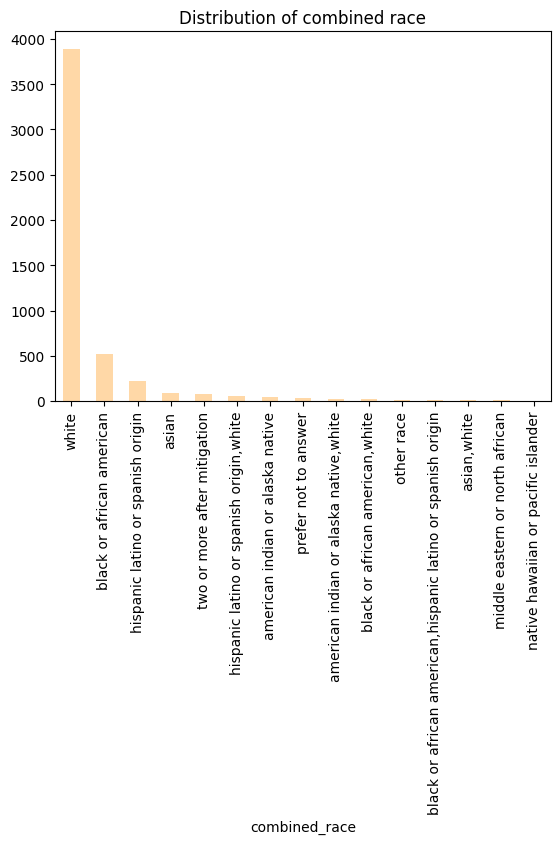

In [225]:

df['combined_race'].value_counts().plot(kind='bar', color='#ffd8a7')
plt.title('Distribution of combined race')
plt.show()


<div style="text-align:center; background-color:#ffeeba; padding:20px;">
  <h1 style="font-size:36px; color:#dc3545;"><b>13. Data Extraction </b></h1>
</div>


In [226]:
df.to_csv('scin_dataset.csv')

In [227]:
import pandas as pd

def filter_images_by_name(dataframe, image_names):
    filtered_dataframe = dataframe[dataframe['image_name'].isin(image_names)]
    return filtered_dataframe

# Define the list of image names
image_names = [
    '2034844842573993364.png',
    '-6754223996189969134.png',
    '4091225911888174490.png',
    '-4649063046758807338.png',
    '-6544442737462623993.png',
    '-6480598833319500800.png',
    '-2197355568033743807.png',
    '-1240400659890187479.png',
    '-4328676342954471143.png',
    '-5609658706270241785.png',
    '4325542435903226725.png',
    '-3779989361448224309.png',
    '-1172506192366462495.png',
    '-773894958411105641.png',
    '-3205742176803893704.png',
    '-4639090956934471841.png',
    '-1153384974921559234.png',
    '-4893312442758095455.png',
    '-1943055598691963873.png',
    '-7030958736860719929.png',
    '-4335509512864210611.png',
    '-3796420587199097151.png',
    '-923054950838727613.png',
    '-7935950081089116729.png',
    '-446206036030978724.png'
]

# Filter the DataFrame based on the provided image names
filtered_df = filter_images_by_name(df, image_names)

filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 4978
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   age_group                                     25 non-null     object 
 1   sex_at_birth                                  25 non-null     object 
 2   fitzpatrick_scale                             25 non-null     object 
 3   related_category                              25 non-null     object 
 4   condition_duration                            25 non-null     object 
 5   image_name                                    25 non-null     object 
 6   image_shot                                    25 non-null     object 
 7   combined_race                                 25 non-null     object 
 8   image_sufficiency                             25 non-null     object 
 9   weighted_skin_condition_label                 25 non-null     object 


In [228]:
filtered_df.to_csv('val_scin.csv')